In [72]:
%reset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [73]:
df = pd.read_csv('Vanguard Portfolio.csv')
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year',inplace=True)
df = df*100
df.head()

,Total Bond Market Index Admiral Shares,Total Stock Market Index Admiral Shares,Municipal Money Market,Prime Money Market,Intermediate-Term Investment-Grade,Short-Term Investment-Grade,Short-Term Tax-Exempt,Balanced Index Admiral Shares,Wellesley Income,500 Index Admiral Shares,Explorer,Mid-Cap Index Admiral Shares,Small-Cap Index Admiral Shares,U.S. Growth,Windsor II,Emerging Markets Stock Index Admiral Shares,International Growth,International Value
Year,,,,,,,,,,,,,,,,,,
2018-01-01,-0.03,-5.17,1.31,1.95,-0.57,0.86,1.59,-2.86,-2.57,-4.43,-2.50,-9.23,-9.31,0.62,-8.58,-14.58,-12.69,-14.52
2017-01-01,3.56,21.17,0.74,1.02,4.15,2.02,0.99,13.89,10.20,21.79,22.95,19.25,16.24,31.60,16.78,31.38,42.96,27.96
2016-01-01,2.60,12.66,0.33,0.49,3.83,2.72,0.36,8.77,8.08,11.93,12.33,11.22,18.30,-0.75,13.41,11.73,1.71,4.46
2015-01-01,0.40,0.39,0.01,0.05,1.53,1.03,0.45,0.51,1.28,1.36,-4.34,-1.34,-3.64,8.47,-3.22,-15.35,-0.67,-6.44
2014-01-01,5.89,12.56,0.01,0.01,5.81,1.76,0.65,9.99,8.07,13.64,3.91,13.76,7.50,13.06,11.16,0.60,-5.63,-6.69


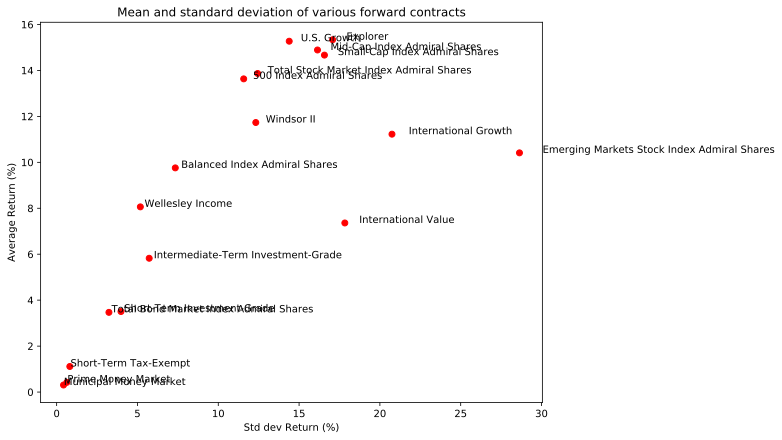

In [74]:
X = df.mean()
Y = df.std()

w_idx = X.index # save indices for future use

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

plt.scatter(Y,X,marker='o',c='r')
plt.title('Mean and standard deviation of various forward contracts')
plt.ylabel('Average Return (%)') 
plt.xlabel('Std dev Return (%)')
for i in range(0,len(X)):
    #ax.annotate("M+%d"%i,xy=(Y[i]*1.05,X[i]))
    ax.annotate(w_idx[i],xy=(Y[i]*1.05,X[i]))

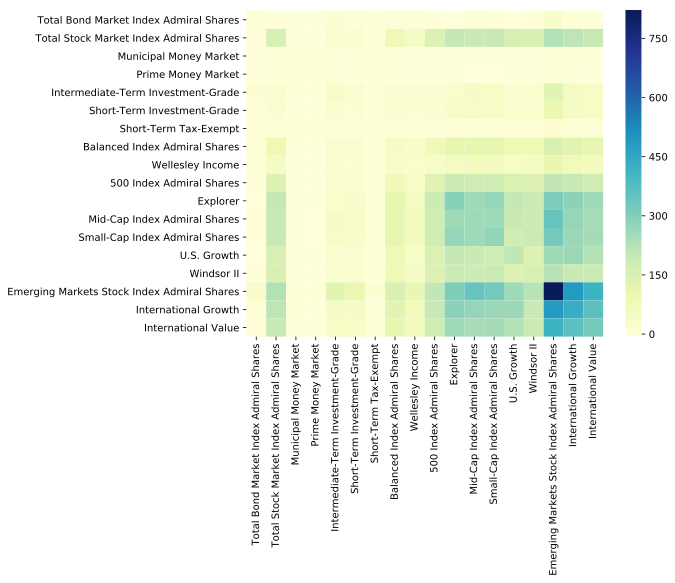

In [80]:
plt.figure(figsize=(8,6))
sns.heatmap(df.cov(),annot=False,fmt='.1f', cmap="YlGnBu");

In [76]:
# Set up optimization problem
import cvxpy as cp

mu = df.mean().to_numpy()
Sigma = df.cov().to_numpy() #np.diag(

n = len(mu)
w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu*w 
risk = cp.quad_form(w, Sigma)

prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])

In [77]:
# Compute trade-off curve for a range of gammas
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
total_w = np.zeros(SAMPLES)
w_optimal = np.zeros((n,SAMPLES))
gamma_vals = np.logspace(-4, 1, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value
    w_optimal[:,i] = w.value
    total_w[i] = np.sum(w.value)
    
w_df = pd.DataFrame(w_optimal)
#w_df.set_index('M+' + w_df.index.astype(str), inplace=True);
w_df.set_index(w_idx,inplace=True)

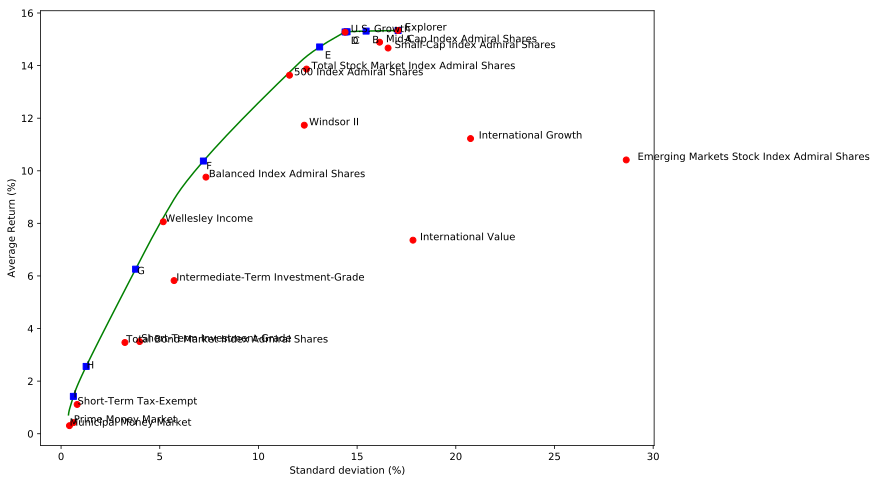

In [78]:
# Plot trade off curve
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plot some points at different gamma values
#np.arange(0,SAMPLES,15)
# find equally spaced points in returns
markers_on = np.searchsorted(ret_data,np.linspace(2,15,7),side='right',sorter=np.arange(SAMPLES,0,-1))-1
#ret_data[-1],ret_data[0]

markers_on = [ 5, 15, 25, 35, 45, 55, 65, 75, 85]

markers_label = list(map(chr, range(65, 65+len(markers_on)))) 

fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for i,marker in enumerate(markers_on):
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    #ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
    #ax.annotate(r"$w = %.2f$" %total_w[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
    #ax.annotate(r"%d" %marker, xy=(risk_data[marker]+.08, ret_data[marker]-.03))
    ax.annotate(markers_label[i], xy=(risk_data[marker]*1.02, ret_data[marker]*.97))
for i in range(n):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro')
    #ax.annotate(i,xy=(cp.sqrt(Sigma[i,i]).value+.3, mu[i]))
    #ax.annotate("M+%d"%i,xy=(cp.sqrt(Sigma[i,i]).value*1.02, mu[i]))
    ax.annotate(w_idx[i],xy=(cp.sqrt(Sigma[i,i]).value*1.02, mu[i]))
plt.xlabel('Standard deviation (%)')
plt.ylabel('Average Return (%)')
plt.show()

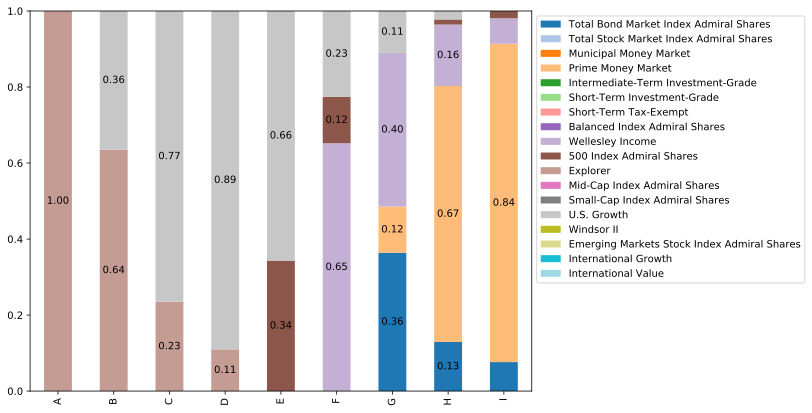

In [79]:
#fig = plt.figure(figsize=(12,8))
#ax = plt.subplot(111)
ax = w_df.iloc[:,markers_on].T.plot(kind='bar',stacked=True,cmap='tab20',legend='right',figsize=(9,7));
ax.set_xticklabels(markers_label)
ax.legend(bbox_to_anchor=(1, 1))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if abs(height) > 0.1:
        ax.text(x+width/2, 
            y+height/2, 
            '{:0.2f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')